# Import Necessary Modules

In [47]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
import IPython.display
import cv2

# Visualize Content Image


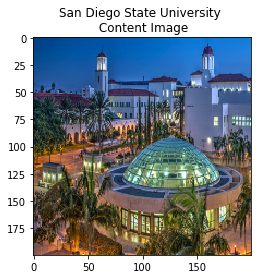

In [48]:
content_path = "sdsu.jpg"
content = cv2.imread("sdsu.jpg")
plt.title("San Diego State University \n Content Image")
plt.imshow(content[:,:,::-1])
plt.show()


# Visualize Style Image

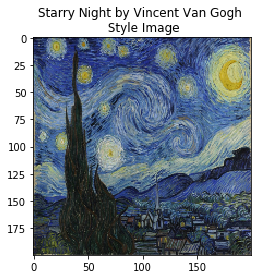

In [49]:
style_path = "starry_night.jpg"
style = cv2.imread("starry_night.jpg")
#style = cv2.imread("scream.jpg")
plt.title("Starry Night by Vincent Van Gogh \n Style Image")
#plt.title("Scream by Edvard Munch \n Style Image")
plt.imshow(style[:,:,::-1])
plt.show()

# Necessary Functions 

In [50]:
def convert_to_tensor(imagepath) :
    image = keras.preprocessing.image.load_img(imagepath)
    image = keras.preprocessing.image.img_to_array(image)
    image = np.expand_dims(image,axis=0)
    image = tf.keras.applications.vgg19.preprocess_input(image)
    return tf.convert_to_tensor(image)

def back_to_image_from_array(image) : 
    image = image.reshape((200,200,3))
    image[:,:,0] += 103.939
    image[:,:,1] += 116.779
    image[:,:,2] += 123.68
    image = image[:,:,::-1]
    image = np.clip(image,0,255).astype("uint8") 
    return image 

def gram_matrix(image) : 
    image = tf.transpose(image,(2,0,1))
    features = tf.reshape(image,(tf.shape(image)[0],-1))
    gram = tf.matmul(features,tf.transpose(features))
    return gram 

def style_loss(style,generated) : 
    S  = gram_matrix(style)
    C = gram_matrix(generated)
    channels = 3 
    size = 200 * 200
    return tf.reduce_sum(tf.square(S-C)) / (4.0 * (channels **2 ) * (size ** 2))

def content_loss(content,generated) : 
    return tf.reduce_sum(tf.square(content-generated))

def compute_loss(generated_image,content_image,style_image) : 
    input_tensor = tf.concat([content_image,style_image,generated_image],axis = 0)
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=()) 
    
    layer_features = features[content_layer_name]
    content_image_features = layer_features[0:,:,:,:]
    generated_image_features = layer_features[2,:,:,:]
    loss = loss + alpha * content_loss(content_image_features,generated_image_features)
    
    for layers in style_layer_names : 
        layer_features = features[layers]
        style_image_features = layer_features[1,:,:,:]
        generated_image_features = layer_features[2,:,:,:]
        sl = style_loss(style_image_features,generated_image_features)
        loss+= (beta / len(style_layer_names)) * sl 
        
    return  loss
    
def compute_loss_and_grads(generated_image,content_image,style_image) : 
    with tf.GradientTape() as tape : 
        loss = compute_loss(generated_image , content_image , style_image) 
    grads = tape.gradient(loss,generated_image)
    
    return loss, grads


# main( ) 

In [59]:
if __name__=="__main__" : 
    
    #Model Selection 
    model = tf.keras.applications.VGG19(weights = "imagenet",include_top=False)
    outputs_dict = dict([(layer.name,layer.output) for layer in model.layers])
    feature_extractor = keras.Model(inputs = model.inputs, outputs = outputs_dict) 
    # Style Layers and Content Layer selection
    style_layer_names = [
        "block1_conv1",
        "block2_conv1",
        "block3_conv1",
        "block4_conv1",
        "block5_conv1"]
    content_layer_name = "block5_conv2"



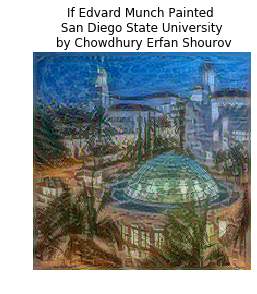

KeyboardInterrupt: 

In [60]:
    #Optimizer for Scream
    optimizer = keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 70.00 , decay_steps = 50 , decay_rate = 0.90))
    #Optimizer for Starry Night
    optimizer_2 = keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 100.0, decay_steps=100,decay_rate=0.96))

    alpha = 2.5e-8
    beta = 1e-6 
    
    content_image = convert_to_tensor("sdsu.jpg")
    style_image = convert_to_tensor("scream.jpg")
    #style_image = convert_to_tensor("starry_night.jpg")
    generated_image = tf.Variable(convert_to_tensor('sdsu.jpg'))

    iterations= 2000 
    for i in range(1,iterations+1) : 
        loss,grads = compute_loss_and_grads(generated_image,content_image,style_image) 
        optimizer.apply_gradients([(grads,generated_image)]) 
        image = back_to_image_from_array(generated_image.numpy()) 
        plt.title("If Edvard Munch Painted \n San Diego State University \n by Chowdhury Erfan Shourov")
        plt.imshow(image)
        plt.axis("off")
        IPython.display.clear_output(wait=True) 
        plt.show() 
